In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, PolynomialFeatures
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, accuracy_score, classification_report, r2_score as r2
from sklearn.model_selection import KFold, RepeatedKFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from pytorch_tabnet.tab_model import TabNetClassifier
from xgboost import XGBClassifier
import torch
import keras
from keras.constraints import max_norm as MaxNorm
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from sklearn.pipeline import make_pipeline
from scikeras.wrappers import KerasClassifier
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

import random
random.seed(42)

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Load Data
df = pd.read_csv('../Data/address_data_combined_ts.csv')

# 2. FIX: Removed 'Unnamed: 0' because it doesn't exist in your file
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

# 3. Split Data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# List of columns to log-transform
columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance','adjusted_eth_value__absolute_sum_of_changes',
     'adjusted_eth_value__mean_abs_change',
     'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
     'adjusted_eth_value__sum_values',
     'adjusted_eth_value__abs_energy',
     'adjusted_eth_value__ratio_value_number_to_time_series_length',
     'adjusted_eth_value__quantile__q_0.1',
     'adjusted_eth_value__count_below__t_0',
     'adjusted_eth_value__count_above__t_0',
     'adjusted_eth_value__median']

scaler = MinMaxScaler()

# 4. Log Transformation
# Note: This loop is fine, but ensures we don't log(0) which is undefined.
for c in columns:
    # Check if column exists first to avoid crashing
    if c in X_train_full.columns:
        X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
        X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# 5. Scaling
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

# 6. FIX: Check for NaNs effectively
# np.isnan() alone returns a huge True/False grid. .sum() counts the errors.
print("Total Missing Values (NaN) in Train:", np.isnan(X_train_full).sum())

Total Missing Values (NaN) in Train: 0


In [4]:
X_train_Xgb, X_test_Xgb, y_train_Xgb, y_Xgb = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [5]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(X_train_full.shape)
X_train_full.head()

(9744, 22)


,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,...,adjusted_eth_value__absolute_sum_of_changes,adjusted_eth_value__mean_abs_change,adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0,adjusted_eth_value__sum_values,adjusted_eth_value__abs_energy,adjusted_eth_value__ratio_value_number_to_time_series_length,adjusted_eth_value__quantile__q_0.1,adjusted_eth_value__count_below__t_0,adjusted_eth_value__count_above__t_0,adjusted_eth_value__median
906,0.00,0.0,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
13918,0.00,0.0,0.00,1,0.500000,0.500000,0.500000,0.000000,0.000000,1,...,0.999861,0.999861,0.500139,0.000139,0.499861,1.0,-0.399875,0.5,0.5,0.000070
5687,159.65,0.5,320.30,2,8.664005,92.335995,50.500000,7.000000,50.499508,4,...,186.335011,62.111670,0.487592,0.000984,17485.815895,1.0,-67.899311,0.5,0.5,0.832003
914,0.00,0.0,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
7100,0.00,0.0,364.87,1,0.259262,0.259262,0.259262,0.258642,0.258642,2,...,0.517904,0.517904,0.501197,0.000620,0.134113,1.0,-0.206852,0.5,0.5,0.000310


In [6]:
# Feature Engineering
from sklearn.preprocessing import MinMaxScaler

columns = ['Avg min between sent tnx', 'Avg min between received tnx',
       'Time Diff between first and last (Mins)',
       'Unique Received From Addresses', 'min value received',
       'max value received ', 'avg val received', 'min val sent',
       'avg val sent', 'total transactions (including tnx to create contract',
       'total ether received', 'total ether balance','adjusted_eth_value__absolute_sum_of_changes',
     'adjusted_eth_value__mean_abs_change',
     'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
     'adjusted_eth_value__sum_values',
     'adjusted_eth_value__abs_energy',
     'adjusted_eth_value__ratio_value_number_to_time_series_length',
     'adjusted_eth_value__quantile__q_0.1',
     'adjusted_eth_value__count_below__t_0',
     'adjusted_eth_value__count_above__t_0',
     'adjusted_eth_value__median']
    
scaler = MinMaxScaler()

# Log for Skewed Data
# log on both train and test data
for c in columns:
    X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)
    X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

# Scaling
# only use training data to fit, to avoid data leakage
X_train_full = scaler.fit_transform(X_train_full)
X_test = scaler.transform(X_test)

np.isnan(X_train_full)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(9744, 22))

In [7]:
# --- IMPORTS ---
from catboost import CatBoostClassifier
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.constraints import max_norm as MaxNorm

# --- OPTIMAL PARAMETERS ---
tabnet_params = {'gamma': 1.0,
                 'lambda_sparse': 0,
                 'momentum': 0.4,
                 'n_steps': 8,
                 'optimizer_params': {'lr': 0.025},
                 'verbose': 0}

xgb_params = {'learning_rate': 0.05,
              'max_depth': 8,
              'n_estimators': 1000}

# Note: Ensure X_train_full is defined before running this
mlp_params = {'input_dim': X_train_full.shape[1],
              'H': 60,
              'activation': 'relu',
              'dropout_probability': 0.2,
              'num_epochs': 75,
              'num_layers': 10}

svm_params = {'C': 1000,
              'gamma': 1}

rf_params = {'max_depth': 20,
               'min_samples_leaf': 5,
               'n_jobs': -1}

lightgbm_params = {"bagging_fraction": 0.95,
                   "bagging_freq": 1,
                   "feature_fraction": 0.95,
                   "learning_rate": 0.2,
                   "max_bin": 300,
                   "max_depth": 6,
                   "min_gain_to_split": 0,
                   "num_leaves": 20}

# --- NEW: CATBOOST PARAMETERS ---
catboost_params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'AUC',
    'verbose': 0,  # Silent training
    'random_seed': 42
}

def compile_mlp(input_dim, H, num_epochs, num_layers, activation, dropout_probability):
    # Creating Sequential MLP
    model_n = Sequential()
    model_n.add(layers.Dense(H, input_shape=(input_dim, ), activation= activation))

    for _ in range(num_layers - 1):
        model_n.add(layers.Dense(H, activation= activation, kernel_constraint=MaxNorm(3)))
        model_n.add(layers.Dropout(dropout_probability))

    model_n.add(layers.Dense(1, activation='sigmoid'))
    # configure the model
    model_n.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.AUC(from_logits=True)])
    return model_n

In [8]:
# get a list of models to evaluate
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier  # <--- 1. Import Added

def get_models():
    models = dict()
    mlp = KerasClassifier(model = compile_mlp, **mlp_params)
    tabnet = TabNetClassifier(**tabnet_params)

    models['tabnet'] = tabnet
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = mlp
    models['lightGBM'] = lgb.LGBMClassifier(**lightgbm_params)
    models['randomforest'] = RandomForestClassifier(**rf_params)

    # --- 2. CatBoost Added Here ---
    # Ensure catboost_params is defined before running this function
    models['catboost'] = CatBoostClassifier(**catboost_params)
    # ------------------------------

    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=42)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)#, error_score='raise')
    return scores

>tabnet 0.899 (0.008)
>svm 0.918 (0.004)
>xgboost 0.929 (0.006)
>mlp 0.811 (0.055)
>lightGBM 0.928 (0.006)
>randomforest 0.911 (0.006)
>catboost 0.931 (0.007)


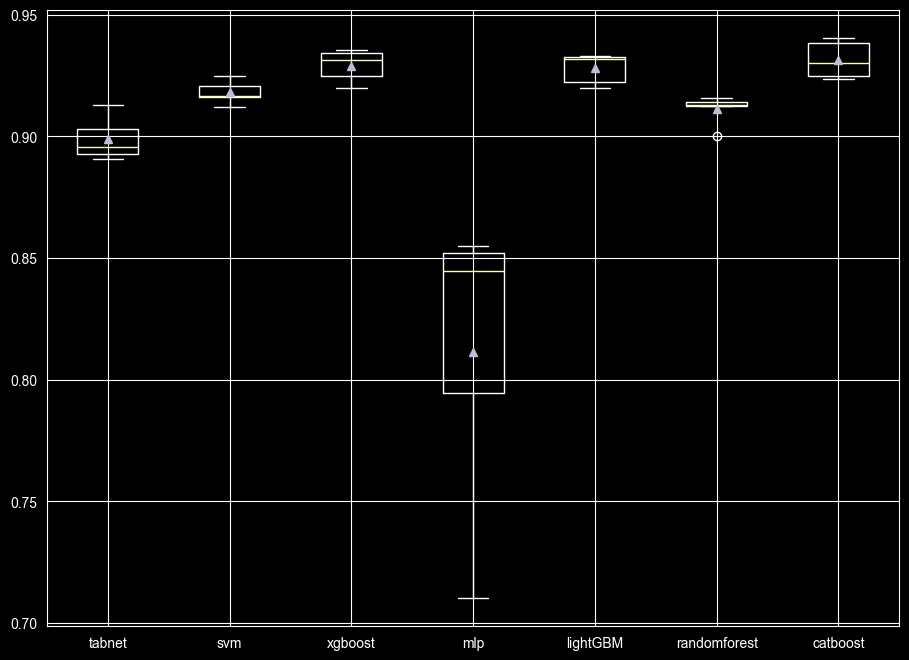

In [9]:
# define dataset
X, y = X_train_full, y_train_full
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    if name == 'xgboost':
        scores = evaluate_model(model, X_train_Xgb, y_train_Xgb)
    else:
        scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [10]:
import warnings
warnings.filterwarnings("ignore")
import time

# Creating Stacking model - Initialized using logistic regression model
def get_stacking():
    # define the base models
    level0 = list()
    # This automatically picks up CatBoost because we updated get_models() earlier
    for key, value in get_models().items():
        try:
            value._estimator_type = 'classifier'
        except AttributeError:
            pass
        finally:
            level0.append([key, value])
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5, n_jobs=-1)
    return model

# Pipeline to get all models
def get_models2():
    models = dict()
    models['tabnet'] = TabNetClassifier(**tabnet_params)
    models['svm'] = svm.SVC(**svm_params)
    models['xgboost'] = XGBClassifier(**xgb_params)
    models['mlp'] = KerasClassifier(model=compile_mlp, **mlp_params)

    # Updated to use your optimal params
    models['lightGBM'] = lgb.LGBMClassifier(**lightgbm_params)

    # --- NEW: ADD CATBOOST HERE ---
    # This ensures it shows up in your final comparison table
    models['catboost'] = CatBoostClassifier(**catboost_params)
    # ------------------------------

    models['stacking'] = get_stacking()
    return models

# Getting predictions from all models to evaluate performance on test set
predictions, names2, timing_list = list(), list(), list()

print("Starting final training loop...")

for name, model in get_models2().items():
    current_time = time.time()

    # Special handling for XGBoost if it uses specific split
    if name == 'xgboost':
        model.fit(X_train_Xgb, y_train_Xgb)
        predictions.append(model.predict(X_test_Xgb))
    else:
        # CatBoost and others fall here (Using standard X, y)
        model.fit(X, y)
        predictions.append(model.predict(X_test))

    names2.append(name)
    final_time = time.time()
    timing_list.append(final_time - current_time)
    print(f"✅ Finished training {name}")

Starting final training loop...
✅ Finished training tabnet
✅ Finished training svm
✅ Finished training xgboost
305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - auc: 0.7773 - loss: 0.5574
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
✅ Finished training mlp
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] bagging_fr

In [11]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
import pandas as pd

results_df = pd.DataFrame()
results_df['Model'] = names2
results_df['Time taken'] = timing_list

# --- UPDATE: Added catboost_params to match the 7 models ---
results_df['Optimal Parameters'] = [
    tabnet_params,
    svm_params,
    xgb_params,
    mlp_params,
    lightgbm_params,
    catboost_params,   # <--- ADDED THIS (Model #6)
    None               # Stacking (Model #7)
]

metrics_dict = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1': f1_score,
    'ROC-AUC': roc_auc_score
}

for metric, func in metrics_dict.items():
    storage = []
    for prediction in predictions:
        storage.append(func(y_test, prediction))
    results_df[metric] = storage

# Display the final leaderboard
results_df.sort_values(['Accuracy', 'ROC-AUC'], ascending=[False, False])

,Model,Time taken,Optimal Parameters,Accuracy,Precision,Recall,F1,ROC-AUC
5,catboost,2.497879,"{'iterations': 1000, 'learning_rate': 0.05, 'd...",0.941092,0.935673,0.933687,0.934679,0.940436
6,stacking,126.420559,None,0.940852,0.934713,0.934218,0.934465,0.940265
2,xgboost,0.958134,"{'learning_rate': 0.05, 'max_depth': 8, 'n_est...",0.940134,0.934148,0.933156,0.933652,0.939516
4,lightGBM,1.248110,"{'bagging_fraction': 0.95, 'bagging_freq': 1, ...",0.933429,0.924907,0.927851,0.926377,0.932935
1,svm,3.123794,"{'C': 1000, 'gamma': 1}",0.928400,0.919577,0.922016,0.920795,0.927835
0,tabnet,36.920127,"{'gamma': 1.0, 'lambda_sparse': 0, 'momentum':...",0.916667,0.911182,0.903448,0.907299,0.915495
3,mlp,1.774095,"{'input_dim': 22, 'H': 60, 'activation': 'relu...",0.873324,0.875415,0.838727,0.856678,0.870258


# savingthe  model xgboost

In [12]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

print("--- 1. Loading and Preparing Data ---")

# 1. Load Data (Make sure the path is correct for your computer)
df = pd.read_csv('../Data/address_data_combined_ts.csv')

# 2. Drop columns we don't need
# Note: We removed 'Unnamed: 0' since your file doesn't have it
X = df.drop(columns=['Address', 'FLAG'])
y = df['FLAG']

# 3. Split the data (This creates the missing 'X_train_full' variable)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Log Transformation (Math stuff to make data better for AI)
columns_to_log = [
    'Avg min between sent tnx', 'Avg min between received tnx',
    'Time Diff between first and last (Mins)', 'Unique Received From Addresses',
    'min value received', 'max value received ', 'avg val received',
    'min val sent', 'avg val sent',
    'total transactions (including tnx to create contract',
    'total ether received', 'total ether balance',
    'adjusted_eth_value__absolute_sum_of_changes',
    'adjusted_eth_value__mean_abs_change',
    'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
    'adjusted_eth_value__sum_values', 'adjusted_eth_value__abs_energy',
    'adjusted_eth_value__ratio_value_number_to_time_series_length',
    'adjusted_eth_value__quantile__q_0.1', 'adjusted_eth_value__count_below__t_0',
    'adjusted_eth_value__count_above__t_0', 'adjusted_eth_value__median'
]

# Apply log safely
for c in columns_to_log:
    if c in X_train_full.columns:
        X_train_full[c] = X_train_full[c].apply(lambda x: np.log(x) if x > 0 else 0)

# 5. Scaling (The Translator)
scaler = MinMaxScaler()
X_train_full = scaler.fit_transform(X_train_full)

print("--- 2. Training the Model ---")

# 6. Define the Winner Model (XGBoost)
best_model = XGBClassifier(
    learning_rate=0.05,
    max_depth=8,
    n_estimators=1000,
    random_state=42
)

# 7. Train it
best_model.fit(X_train_full, y_train_full)
print("Model Trained!")

print("--- 3. Saving Files ---")

# 8. Create 'models' folder if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created new 'models' folder.")

# 9. Save both the Brain (Model) and the Translator (Scaler)
joblib.dump(best_model, 'models/my_best_fraud_model.pkl')
joblib.dump(scaler, 'models/scaler.pkl')

print("Success! Files saved in 'models/' folder.")

--- 1. Loading and Preparing Data ---
--- 2. Training the Model ---
Model Trained!
--- 3. Saving Files ---
Success! Files saved in 'models/' folder.


In [13]:
# --- FRAUD HUNTER SCRIPT ---
import pandas as pd

# 1. Load the data again
df = pd.read_csv('../Data/address_data_combined_ts.csv')

# 2. Filter: Find rows where FLAG is 1 (Confirmed Fraud)
# We also want a "Clear" example, so let's pick one with high transaction count
real_fraudsters = df[ (df['FLAG'] == 1) & (df['total transactions (including tnx to create contract'] > 10) ]

# 3. Pick the first one found
fraud_row = real_fraudsters.iloc[0]

# 4. Print it as a Dictionary so you can copy-paste it
print("fake_data = {")
for col in fraud_row.index:
    if col not in ['Address', 'FLAG', 'Unnamed: 0']:
        print(f"    '{col}': [{fraud_row[col]}],")
print("}")

--- 🚨 COPY THIS DATA INTO YOUR TEST SCRIPT ---
fake_data = {
    'Avg min between sent tnx': [1179.02],
    'Avg min between received tnx': [1124.89],
    'Time Diff between first and last (Mins)': [25126.45],
    'Unique Received From Addresses': [13],
    'min value received': [0.0],
    'max value received ': [0.75],
    'avg val received': [0.176666667],
    'min val sent': [0.145],
    'avg val sent': [0.419269824],
    'total transactions (including tnx to create contract': [22],
    'total ether received': [2.65],
    'total ether balance': [-0.28488877],
    'adjusted_eth_value__absolute_sum_of_changes': [7.66977754],
    'adjusted_eth_value__mean_abs_change': [0.3652275019047619],
    'adjusted_eth_value__energy_ratio_by_chunks__num_segments_10__segment_focus_0': [0.0202370540854782],
    'adjusted_eth_value__sum_values': [-0.2848887700000001],
    'adjusted_eth_value__abs_energy': [3.335465711308085],
    'adjusted_eth_value__ratio_value_number_to_time_series_length': [0.4090